В первую очередь, необходимо определить целевой класс в нашем датасете, однако это не так просто. Я предлагаю не изменять сам датасет, а создать бинарный столбец, который будет отражать, произошло ли увеличение или снижение цены. Этот столбец можно сформировать, сравнивая цену закрытия и цену открытия: если цена закрытия выше, то присваиваем значение 1, в противном случае — 0.

В нашей программе мы добавим новый столбец к каждой записи и подсчитаем количество случаев роста и падения цен. Для более точных результатов важно, чтобы количество значений в одном классе было примерно равно количеству значений в другом классе.

In [13]:
import pandas as pd

data_cleaned = pd.read_csv('Up_Apple.csv')

data_cleaned['Price dynamics'] = (data_cleaned['Close'] > data_cleaned['Open']).astype(int)
class_distribution = data_cleaned['Price dynamics'].value_counts()
print(f"Распределение классов:\n{class_distribution.to_string()}")
f"\nБаланс классов:\n{data_cleaned['Price dynamics'].value_counts(normalize=True).to_string()}"
print(f"\nБаланс классов:\n{data_cleaned['Price dynamics'].value_counts(normalize=True).to_string()}")

Распределение классов:
Price dynamics
0    5482
1    4534

Баланс классов:
Price dynamics
0    0.547324
1    0.452676


Далее мы будем оценивать нашу классификацию с использованием следующих алгоритмов:
 - kNN — алгоритм, основанный на сходстве данных.
 - Дерево решений — алгоритм, который строит дерево, где на каждом узле выбирается атрибут для разбиения.

Для сравнения результатов мы воспользуемся следующими метриками:
 - Accuracy — показывает долю правильно предсказанных положительных объектов среди всех предсказанных.
 - Precision — отражает долю правильно предсказанных положительных объектов среди всех реальных положительных случаев.
 - Recall — позволяет выявить все положительные случаи.
 - F-measure — представляет собой среднее значение между Precision и Recall, что особенно важно, когда необходимо сбалансировать оба показателя.

В нашем примере точность классификации для kNN составила 52%. Однако не следует полагаться исключительно на точность (Accuracy), так как она может давать искаженные результаты в случае несбалансированных классов (когда один класс преобладает). Поэтому мы также рассмотрим другие показатели. Для пояснения в выводе программы: support — это реальное количество таких случаев, macro avg — среднее всех показателей, а weighted avg — взвешенное среднее для большей точности.

Для дерева решений точность составила 70%, а остальные метрики были описаны выше.

Исходя из этих показателей, мы наблюдаем различия, что указывает на несбалансированность нашего примера, что может быть связано с дублированием данных.

Кроме того, нам необходимо построить ROC-кривую, чтобы более наглядно продемонстрировать различия. Все это свидетельствует о том, что модель (дерево решений) лучше предсказывает классы и демонстрирует хорошие характеристики!

Также в нашем датасете присутствует NaN. С этим значение я боролся с помощью импутации пропущенных значений(Этот подход заполняет пропущенные значения средними значениями каждого столбца.)

Accuracy (kNN): 0.5231281198003328

Classification Report (kNN):
               precision    recall  f1-score   support

           0       0.57      0.58      0.58      1680
           1       0.46      0.45      0.45      1325

    accuracy                           0.52      3005
   macro avg       0.52      0.52      0.52      3005
weighted avg       0.52      0.52      0.52      3005


Accuracy (Decision Tree): 0.7034941763727122

Classification Report (Decision Tree):
               precision    recall  f1-score   support

           0       0.74      0.72      0.73      1680
           1       0.66      0.68      0.67      1325

    accuracy                           0.70      3005
   macro avg       0.70      0.70      0.70      3005
weighted avg       0.70      0.70      0.70      3005



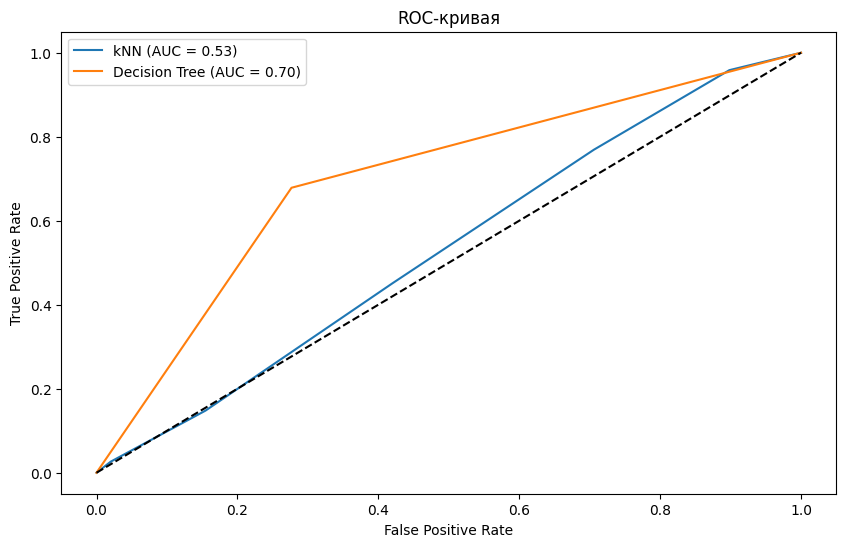

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

data_cleaned = pd.read_csv('Up_Apple.csv')

data_cleaned['Price Direction'] = (data_cleaned['Close'] > data_cleaned['Open']).astype(int)

X = data_cleaned[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
y = data_cleaned['Price Direction']

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("Accuracy (kNN):", accuracy_score(y_test, y_pred_knn))
print("\nClassification Report (kNN):\n", classification_report(y_test, y_pred_knn))

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

print("\nAccuracy (Decision Tree):", accuracy_score(y_test, y_pred_tree))
print("\nClassification Report (Decision Tree):\n", classification_report(y_test, y_pred_tree))

y_pred_knn_proba = knn.predict_proba(X_test)[:, 1]
roc_auc_knn = roc_auc_score(y_test, y_pred_knn_proba)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn_proba)

y_pred_tree_proba = tree.predict_proba(X_test)[:, 1]
roc_auc_tree = roc_auc_score(y_test, y_pred_tree_proba)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_pred_tree_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr_knn, tpr_knn, label=f'kNN (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {roc_auc_tree:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC-кривая')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


Вывод: В процессе работы мы ознакомились с рядом метрик и алгоритмов классификации, которые способствуют предсказанию классов.